# Stitched inversion of 2D field data

In [1]:
import numpy as np
from SimPEG.electromagnetics import natural_source as nsem
from SimPEG import maps
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib
import matplotlib.gridspec as gridspec
from SimPEG.utils import plot_1d_layer_model
from discretize import TensorMesh
from SimPEG import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
    utils,
)

## Step 1: Import Yellowstone MT data in `mth5` format

In [2]:
from mtpy import MTCollection
mc = MTCollection()
mc.open_collection("../../data/transfer_functions/yellowstone_mt_collection.h5")

C:\Users\sgkan\anaconda3\envs\em\lib\site-packages\pkg_resources\__init__.py:123: PkgResourcesDeprecationWarning: -PKG-VERSION is an invalid version and will not be supported in a future release
  warnings.warn(
2022-10-19 19:18:13,535 [line 135] mth5.setup_logger - INFO: Logging file can be found C:\Users\sgkan\anaconda3\envs\em\lib\site-packages\mth5-0.3.0-py3.9.egg\logs\mth5_debug.log


In [3]:
# Extract 2D line
ii = 1
kk = -7
inds_sr = ['SR' in station for station in mc.dataframe['station'].values]
station_ids = mc.dataframe['station'].values[inds_sr][ii:kk]
lat = mc.dataframe['latitude'].values[inds_sr][ii:kk]
lon = mc.dataframe['longitude'].values[inds_sr][ii:kk]

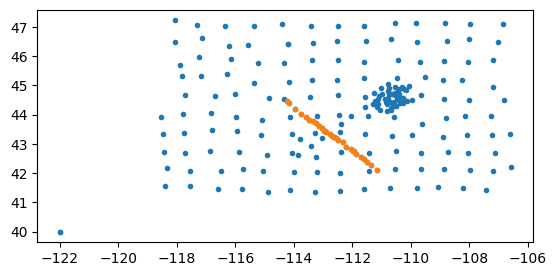

In [4]:
plt.plot(mc.dataframe['longitude'].values, mc.dataframe['latitude'].values, '.')
plt.plot(lon, lat, '.')
plt.gca().set_aspect(1)

## Step 2: Visulize transfer function at each station

In [5]:
from ipywidgets import widgets, interact
station_names = mc.dataframe.station.values
def foo(name, component):
    tf = mc.get_tf(name)
    tf.plot_mt_response()
Q = interact(
    foo, 
    name=widgets.Select(options=station_ids),
    component=widgets.RadioButtons(options=['xy', 'yx', 'det'], value='xy')
)

interactive(children=(Select(description='name', options=('SR205', 'SR209', 'SR212', 'SR216', 'SR220', 'SR222'…

## Step 3: Design a 1D vertical mesh

In [6]:
from geoana.em.fdem import skin_depth
tf = mc.get_tf(station_ids[0])
f_min = tf.frequency.min()
f_max = tf.frequency.max()
z_max = skin_depth(f_min, 1e-2) * 1
print (z_max/1e3)
z_min = skin_depth(f_max, 1e-2) / 5
print (z_min/1e3)

2022-10-19 19:18:16,422 [line 275] mtpy.core.mt_collection.MTCollection.get_tf - WARNING: Found multiple transfer functions with ID SR205. Suggest setting survey, otherwise returning the TF from survey Yellowstone-Snake_River_Plain.


688.6936173947421
2.7223014526313616


In [7]:
n_layer = 21
z_factor = 1.2
layer_thicknesses_inv = z_min*z_factor**np.arange(n_layer-1)[::-1]
print (z_max/1e3, np.sum(layer_thicknesses_inv)/1e3)

688.6936173947421 508.22101256083084


## Step 4: Run separate 1D inversions

In [8]:
def run_fixed_layer_inversion(
    dobs,
    standard_deviation,
    rho_0,
    rho_ref,
    maxIter=10,
    maxIterCG=30,
    alpha_s=1e-10,
    alpha_z=1,
    beta0_ratio=1,
    coolingFactor=2,
    coolingRate=1,
    chi_factor=1,
    use_irls=False,
    p_s=2,
    p_z=2
    
):
    mesh_inv = TensorMesh([(np.r_[layer_thicknesses_inv, layer_thicknesses_inv[-1]])], "N")
    receivers_list = [
        nsem.receivers.PointNaturalSource(component="app_res"),
        nsem.receivers.PointNaturalSource(component="phase"),
    ]

    source_list = []
    for freq in frequencies:
        source_list.append(nsem.sources.Planewave(receivers_list, freq))

    survey = nsem.survey.Survey(source_list)

    sigma_map = maps.ExpMap(nP=len(layer_thicknesses_inv)+1)
    simulation = nsem.simulation_1d.Simulation1DRecursive(
        survey=survey, 
        sigmaMap=sigma_map,
        thicknesses=layer_thicknesses_inv,
    )
    # Define the data 
    data_object = data.Data(survey, dobs=dobs, standard_deviation=standard_deviation)    
    
    # Initial model
    m0 = np.ones(len(layer_thicknesses_inv)+1) * np.log(1./rho_0)
    
    # Reference model
    mref = np.ones(len(layer_thicknesses_inv)+1) * np.log(1./rho_ref)    
    
    dmis = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)

    # Define the regularization (model objective function)
    reg = regularization.Sparse(mesh_inv, alpha_s=alpha_s, alpha_x=alpha_z, mref=mref, mapping=maps.IdentityMap(mesh_inv))

    # Define how the optimization problem is solved. Here we will use an inexact
    # Gauss-Newton approach that employs the conjugate gradient solver.
    opt = optimization.InexactGaussNewton(maxIter=maxIter, maxIterCG=maxIterCG)

    # Define the inverse problem
    inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

    #######################################################################
    # Define Inversion Directives
    # ---------------------------
    #
    # Here we define any directives that are carried out during the inversion. This
    # includes the cooling schedule for the trade-off parameter (beta), stopping
    # criteria for the inversion and saving inversion results at each iteration.
    #

    # Defining a starting value for the trade-off parameter (beta) between the data
    # misfit and the regularization.
    starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=beta0_ratio)

    # Set the rate of reduction in trade-off parameter (beta) each time the
    # the inverse problem is solved. And set the number of Gauss-Newton iterations
    # for each trade-off paramter value.
    beta_schedule = directives.BetaSchedule(coolingFactor=coolingFactor, coolingRate=coolingRate)
    save_dictionary = directives.SaveOutputDictEveryIteration()
    save_dictionary.outDict = {}
    # Setting a stopping criteria for the inversion.
    target_misfit = directives.TargetMisfit(chifact=chi_factor)
    if use_irls:
        reg.norms = np.c_[p_s, p_z]
        # Reach target misfit for L2 solution, then use IRLS until model stops changing.
        IRLS = directives.Update_IRLS(max_irls_iterations=40, minGNiter=1, f_min_change=1e-5)

        # The directives are defined as a list.
        directives_list = [
            IRLS,
            starting_beta,
            save_dictionary,
        ]
    else:
        # The directives are defined as a list.
        directives_list = [
            starting_beta,
            beta_schedule,
            target_misfit,
            save_dictionary
        ]

    #####################################################################
    # Running the Inversion
    # ---------------------
    #
    # To define the inversion object, we need to define the inversion problem and
    # the set of directives. We can then run the inversion.
    #

    # Here we combine the inverse problem and the set of directives
    inv = inversion.BaseInversion(inv_prob, directives_list)

    # Run the inversion
    recovered_model = inv.run(m0)    
    
    return recovered_model, inv_prob.phi_d

In [9]:
resistivity_models = []
phid_s = []
# Relative error for apparent resistivity
relative_error_rho = 0.05
# Floor for phase
floor_phase = 2.
rho_0  = 100.

rho_ref = 100.
for i_station in range(len(station_ids)):
    tf = mc.get_tf(station_ids[i_station])
    dobs = np.c_[tf.Z.res_det, tf.Z.phase_det].flatten()
    dobs_error = np.c_[tf.Z.res_err_det, tf.Z.phase_err_det].flatten()    

    frequencies = tf.frequency
    rho_app = dobs.reshape((len(frequencies), 2))[:,0]
    phase = dobs.reshape((len(frequencies), 2))[:,1]
    standard_deviation = np.c_[abs(rho_app)*relative_error_rho, np.ones(len(phase))*floor_phase].flatten() 
    recovered_model, phi_d = run_fixed_layer_inversion(
        dobs,
        standard_deviation,
        rho_0,
        rho_ref,
        maxIter=5,
        maxIterCG=30,
        alpha_s=1e-5,
        alpha_z=1,
        beta0_ratio=1,
        coolingFactor=2,
        coolingRate=1,
        chi_factor=1
    )
    phid_s.append(phi_d)
    resistivity_models.append(1./np.exp(recovered_model))

2022-10-19 19:18:16,799 [line 275] mtpy.core.mt_collection.MTCollection.get_tf - WARNING: Found multiple transfer functions with ID SR205. Suggest setting survey, otherwise returning the TF from survey Yellowstone-Snake_River_Plain.



        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.51e+01  6.23e+05  0.00e+00  6.23e+05    3.29e+05      0              
   1  7.55e+00  7.58e+04  2.04e+00  7.58e+04    4.83e+04      0              
   2  3.77e+00  9.46e+03  7.05e+00  9.49e+03    7.32e+03      0   Skip BFGS  
   3  1.89e+00  2.01e+03  7.63e+01  2.16e+03    1.24e+03      0   Skip BFGS  


2022-10-19 19:18:18,351 [line 275] mtpy.core.mt_collection.MTCollection.get_tf - WARNING: Found multiple transfer functions with ID SR209. Suggest setting survey, otherwise returning the TF from survey Yellowstone-Snake_River_Plain.


   4  9.43e-01  1.18e+03  2.27e+02  1.39e+03    4.97e+02      0   Skip BFGS  
   5  4.72e-01  8.55e+02  4.60e+02  1.07e+03    4.18e+02      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 3.2102e+02 <= tolF*(1+|f0|) = 6.2322e+04
1 : |xc-x_last| = 5.8625e-01 <= tolX*(1+|x0|) = 2.2104e+00
0 : |proj(x-g)-x|    = 4.1801e+02 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 4.1801e+02 <= 1e3*eps       = 1.0000e-02
1 : maxIter   =       5    <= iter          =      5
------------------------- DONE! -------------------------

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  8.08e

2022-10-19 19:18:19,719 [line 275] mtpy.core.mt_collection.MTCollection.get_tf - WARNING: Found multiple transfer functions with ID SR212. Suggest setting survey, otherwise returning the TF from survey Yellowstone-Snake_River_Plain.


   5  2.53e+01  3.30e+03  4.58e+01  4.46e+03    2.30e+03      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 1.1468e+04 <= tolF*(1+|f0|) = 5.3277e+06
0 : |xc-x_last| = 2.7204e+00 <= tolX*(1+|x0|) = 2.2104e+00
0 : |proj(x-g)-x|    = 2.3017e+03 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 2.3017e+03 <= 1e3*eps       = 1.0000e-02
1 : maxIter   =       5    <= iter          =      5
------------------------- DONE! -------------------------

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  5.51e+02  2.36e+07  0.00e+00  2.36e+07    1.33e+07      0              
   1  2.75e

2022-10-19 19:18:21,217 [line 275] mtpy.core.mt_collection.MTCollection.get_tf - WARNING: Found multiple transfer functions with ID SR216. Suggest setting survey, otherwise returning the TF from survey Yellowstone-Snake_River_Plain.


   5  1.72e+01  5.14e+03  4.03e+01  5.84e+03    1.34e+03      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 4.5570e+03 <= tolF*(1+|f0|) = 2.3586e+06
1 : |xc-x_last| = 1.8991e+00 <= tolX*(1+|x0|) = 2.2104e+00
0 : |proj(x-g)-x|    = 1.3354e+03 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 1.3354e+03 <= 1e3*eps       = 1.0000e-02
1 : maxIter   =       5    <= iter          =      5
------------------------- DONE! -------------------------

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.39e+00  5.59e+04  0.00e+00  5.59e+04    3.42e+04      0              
   1  6.95e

2022-10-19 19:18:22,712 [line 275] mtpy.core.mt_collection.MTCollection.get_tf - WARNING: Found multiple transfer functions with ID SR220. Suggest setting survey, otherwise returning the TF from survey Yellowstone-Snake_River_Plain.


   5  4.34e-02  1.13e+02  3.11e+03  2.48e+02    7.77e+01      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 1.7712e+02 <= tolF*(1+|f0|) = 5.5923e+03
1 : |xc-x_last| = 9.6325e-01 <= tolX*(1+|x0|) = 2.2104e+00
0 : |proj(x-g)-x|    = 7.7698e+01 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 7.7698e+01 <= 1e3*eps       = 1.0000e-02
1 : maxIter   =       5    <= iter          =      5
------------------------- DONE! -------------------------

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.21e+00  1.00e+05  0.00e+00  1.00e+05    5.90e+04      0              
   1  1.11e

2022-10-19 19:18:24,156 [line 275] mtpy.core.mt_collection.MTCollection.get_tf - WARNING: Found multiple transfer functions with ID SR222. Suggest setting survey, otherwise returning the TF from survey Yellowstone-Snake_River_Plain.


   5  6.92e-02  3.20e+02  2.10e+03  4.65e+02    1.18e+02      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 1.9527e+02 <= tolF*(1+|f0|) = 1.0038e+04
1 : |xc-x_last| = 7.3675e-01 <= tolX*(1+|x0|) = 2.2104e+00
0 : |proj(x-g)-x|    = 1.1786e+02 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 1.1786e+02 <= 1e3*eps       = 1.0000e-02
1 : maxIter   =       5    <= iter          =      5
------------------------- DONE! -------------------------

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.01e+02  5.77e+06  0.00e+00  5.77e+06    3.06e+06      0              
   1  5.05e

2022-10-19 19:18:25,566 [line 275] mtpy.core.mt_collection.MTCollection.get_tf - WARNING: Found multiple transfer functions with ID SR225. Suggest setting survey, otherwise returning the TF from survey Yellowstone-Snake_River_Plain.


   5  3.16e+00  2.23e+03  5.19e+01  2.39e+03    6.73e+02      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 7.2681e+02 <= tolF*(1+|f0|) = 5.7738e+05
1 : |xc-x_last| = 1.0936e+00 <= tolX*(1+|x0|) = 2.2104e+00
0 : |proj(x-g)-x|    = 6.7310e+02 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 6.7310e+02 <= 1e3*eps       = 1.0000e-02
1 : maxIter   =       5    <= iter          =      5
------------------------- DONE! -------------------------

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  6.03e-01  1.74e+04  0.00e+00  1.74e+04    1.25e+04      0              
   1  3.01e

2022-10-19 19:18:27,043 [line 275] mtpy.core.mt_collection.MTCollection.get_tf - WARNING: Found multiple transfer functions with ID SR227. Suggest setting survey, otherwise returning the TF from survey Yellowstone-Snake_River_Plain.


   5  1.88e-02  5.41e+01  2.89e+03  1.08e+02    3.00e+01      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 6.3862e+01 <= tolF*(1+|f0|) = 1.7414e+03
1 : |xc-x_last| = 6.1462e-01 <= tolX*(1+|x0|) = 2.2104e+00
0 : |proj(x-g)-x|    = 2.9984e+01 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 2.9984e+01 <= 1e3*eps       = 1.0000e-02
1 : maxIter   =       5    <= iter          =      5
------------------------- DONE! -------------------------

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  8.62e+01  4.15e+06  0.00e+00  4.15e+06    2.25e+06      0              
   1  4.31e

2022-10-19 19:18:28,464 [line 275] mtpy.core.mt_collection.MTCollection.get_tf - WARNING: Found multiple transfer functions with ID SR229. Suggest setting survey, otherwise returning the TF from survey Yellowstone-Snake_River_Plain.


   5  2.69e+00  2.30e+03  5.75e+01  2.45e+03    6.49e+02      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 4.9769e+02 <= tolF*(1+|f0|) = 4.1503e+05
1 : |xc-x_last| = 6.9664e-01 <= tolX*(1+|x0|) = 2.2104e+00
0 : |proj(x-g)-x|    = 6.4935e+02 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 6.4935e+02 <= 1e3*eps       = 1.0000e-02
1 : maxIter   =       5    <= iter          =      5
------------------------- DONE! -------------------------

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  6.37e-01  1.75e+04  0.00e+00  1.75e+04    1.26e+04      0              
   1  3.18e

2022-10-19 19:18:30,062 [line 275] mtpy.core.mt_collection.MTCollection.get_tf - WARNING: Found multiple transfer functions with ID SR232. Suggest setting survey, otherwise returning the TF from survey Yellowstone-Snake_River_Plain.


   5  1.99e-02  5.06e+01  2.34e+03  9.72e+01    3.50e+01      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 5.6924e+01 <= tolF*(1+|f0|) = 1.7534e+03
1 : |xc-x_last| = 5.7684e-01 <= tolX*(1+|x0|) = 2.2104e+00
0 : |proj(x-g)-x|    = 3.4961e+01 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 3.4961e+01 <= 1e3*eps       = 1.0000e-02
1 : maxIter   =       5    <= iter          =      5
------------------------- DONE! -------------------------

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.01e+01  3.51e+05  0.00e+00  3.51e+05    2.06e+05      0              
   1  5.05e

2022-10-19 19:18:31,478 [line 275] mtpy.core.mt_collection.MTCollection.get_tf - WARNING: Found multiple transfer functions with ID SR236. Suggest setting survey, otherwise returning the TF from survey Yellowstone-Snake_River_Plain.


   5  3.15e-01  6.26e+02  5.63e+02  8.03e+02    2.88e+02      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 2.5464e+02 <= tolF*(1+|f0|) = 3.5122e+04
1 : |xc-x_last| = 4.6144e-01 <= tolX*(1+|x0|) = 2.2104e+00
0 : |proj(x-g)-x|    = 2.8848e+02 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 2.8848e+02 <= 1e3*eps       = 1.0000e-02
1 : maxIter   =       5    <= iter          =      5
------------------------- DONE! -------------------------

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.35e+00  7.03e+04  0.00e+00  7.03e+04    4.56e+04      0              
   1  1.18e

2022-10-19 19:18:32,993 [line 275] mtpy.core.mt_collection.MTCollection.get_tf - WARNING: Found multiple transfer functions with ID SR238. Suggest setting survey, otherwise returning the TF from survey Yellowstone-Snake_River_Plain.


   5  7.35e-02  2.53e+02  1.35e+03  3.53e+02    9.79e+01      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 1.2692e+02 <= tolF*(1+|f0|) = 7.0303e+03
1 : |xc-x_last| = 7.0415e-01 <= tolX*(1+|x0|) = 2.2104e+00
0 : |proj(x-g)-x|    = 9.7927e+01 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 9.7927e+01 <= 1e3*eps       = 1.0000e-02
1 : maxIter   =       5    <= iter          =      5
------------------------- DONE! -------------------------

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.03e+00  2.54e+04  0.00e+00  2.54e+04    1.83e+04      0              
   1  5.14e

2022-10-19 19:18:34,525 [line 275] mtpy.core.mt_collection.MTCollection.get_tf - WARNING: Found multiple transfer functions with ID SR240. Suggest setting survey, otherwise returning the TF from survey Yellowstone-Snake_River_Plain.


   5  3.21e-02  1.11e+02  1.90e+03  1.71e+02    5.32e+01      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 7.7627e+01 <= tolF*(1+|f0|) = 2.5409e+03
1 : |xc-x_last| = 6.1818e-01 <= tolX*(1+|x0|) = 2.2104e+00
0 : |proj(x-g)-x|    = 5.3199e+01 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 5.3199e+01 <= 1e3*eps       = 1.0000e-02
1 : maxIter   =       5    <= iter          =      5
------------------------- DONE! -------------------------

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.15e+01  1.13e+06  0.00e+00  1.13e+06    6.31e+05      0              
   1  1.07e

2022-10-19 19:18:35,964 [line 275] mtpy.core.mt_collection.MTCollection.get_tf - WARNING: Found multiple transfer functions with ID SR244. Suggest setting survey, otherwise returning the TF from survey Yellowstone-Snake_River_Plain.


   5  6.71e-01  9.12e+02  2.80e+02  1.10e+03    4.37e+02      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 2.6918e+02 <= tolF*(1+|f0|) = 1.1251e+05
1 : |xc-x_last| = 3.7994e-01 <= tolX*(1+|x0|) = 2.2104e+00
0 : |proj(x-g)-x|    = 4.3736e+02 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 4.3736e+02 <= 1e3*eps       = 1.0000e-02
1 : maxIter   =       5    <= iter          =      5
------------------------- DONE! -------------------------

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.13e+01  5.83e+05  0.00e+00  5.83e+05    3.30e+05      0              
   1  5.67e

2022-10-19 19:18:37,399 [line 275] mtpy.core.mt_collection.MTCollection.get_tf - WARNING: Found multiple transfer functions with ID SR247. Suggest setting survey, otherwise returning the TF from survey Yellowstone-Snake_River_Plain.


   5  3.54e-01  5.03e+02  5.16e+02  6.85e+02    3.12e+02      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 2.5651e+02 <= tolF*(1+|f0|) = 5.8289e+04
1 : |xc-x_last| = 4.3083e-01 <= tolX*(1+|x0|) = 2.2104e+00
0 : |proj(x-g)-x|    = 3.1239e+02 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 3.1239e+02 <= 1e3*eps       = 1.0000e-02
1 : maxIter   =       5    <= iter          =      5
------------------------- DONE! -------------------------

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  3.93e+00  1.23e+05  0.00e+00  1.23e+05    7.65e+04      0              
   1  1.97e

2022-10-19 19:18:38,836 [line 275] mtpy.core.mt_collection.MTCollection.get_tf - WARNING: Found multiple transfer functions with ID SR250. Suggest setting survey, otherwise returning the TF from survey Yellowstone-Snake_River_Plain.


   5  1.23e-01  2.42e+02  8.47e+02  3.46e+02    1.30e+02      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 1.3574e+02 <= tolF*(1+|f0|) = 1.2335e+04
1 : |xc-x_last| = 4.8660e-01 <= tolX*(1+|x0|) = 2.2104e+00
0 : |proj(x-g)-x|    = 1.2960e+02 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 1.2960e+02 <= 1e3*eps       = 1.0000e-02
1 : maxIter   =       5    <= iter          =      5
------------------------- DONE! -------------------------

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  4.58e+00  2.15e+05  0.00e+00  2.15e+05    1.20e+05      0              
   1  2.29e

2022-10-19 19:18:40,192 [line 275] mtpy.core.mt_collection.MTCollection.get_tf - WARNING: Found multiple transfer functions with ID SR252. Suggest setting survey, otherwise returning the TF from survey Yellowstone-Snake_River_Plain.


   5  1.43e-01  1.82e+04  5.01e+03  1.89e+04    7.83e+02      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 1.0746e+03 <= tolF*(1+|f0|) = 2.1452e+04
0 : |xc-x_last| = 1.0560e+01 <= tolX*(1+|x0|) = 2.2104e+00
0 : |proj(x-g)-x|    = 7.8325e+02 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 7.8325e+02 <= 1e3*eps       = 1.0000e-02
1 : maxIter   =       5    <= iter          =      5
------------------------- DONE! -------------------------

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  8.38e-01  2.31e+04  0.00e+00  2.31e+04    1.48e+04      0              
   1  4.19e

2022-10-19 19:18:41,679 [line 275] mtpy.core.mt_collection.MTCollection.get_tf - WARNING: Found multiple transfer functions with ID SR255. Suggest setting survey, otherwise returning the TF from survey Yellowstone-Snake_River_Plain.


   5  2.62e-02  4.71e+03  2.18e+03  4.76e+03    9.14e+01      1              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 7.0064e+01 <= tolF*(1+|f0|) = 2.3147e+03
0 : |xc-x_last| = 4.2522e+00 <= tolX*(1+|x0|) = 2.2104e+00
0 : |proj(x-g)-x|    = 9.1351e+01 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 9.1351e+01 <= 1e3*eps       = 1.0000e-02
1 : maxIter   =       5    <= iter          =      5
------------------------- DONE! -------------------------

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.02e+00  7.96e+04  0.00e+00  7.96e+04    5.08e+04      0              
   1  1.01e

2022-10-19 19:18:43,118 [line 275] mtpy.core.mt_collection.MTCollection.get_tf - WARNING: Found multiple transfer functions with ID SR258. Suggest setting survey, otherwise returning the TF from survey Yellowstone-Snake_River_Plain.


   5  6.32e-02  1.09e+03  2.06e+03  1.22e+03    1.04e+02      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 1.6369e+02 <= tolF*(1+|f0|) = 7.9586e+03
0 : |xc-x_last| = 6.8431e+00 <= tolX*(1+|x0|) = 2.2104e+00
0 : |proj(x-g)-x|    = 1.0380e+02 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 1.0380e+02 <= 1e3*eps       = 1.0000e-02
1 : maxIter   =       5    <= iter          =      5
------------------------- DONE! -------------------------

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  3.62e+00  1.57e+05  0.00e+00  1.57e+05    9.38e+04      0              
   1  1.81e

2022-10-19 19:18:44,624 [line 275] mtpy.core.mt_collection.MTCollection.get_tf - WARNING: Found multiple transfer functions with ID SR264. Suggest setting survey, otherwise returning the TF from survey Yellowstone-Snake_River_Plain.


   5  1.13e-01  2.17e+02  1.14e+03  3.45e+02    1.34e+02      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 1.7106e+02 <= tolF*(1+|f0|) = 1.5660e+04
1 : |xc-x_last| = 5.5699e-01 <= tolX*(1+|x0|) = 2.2104e+00
0 : |proj(x-g)-x|    = 1.3428e+02 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 1.3428e+02 <= 1e3*eps       = 1.0000e-02
1 : maxIter   =       5    <= iter          =      5
------------------------- DONE! -------------------------

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.57e-02  3.11e+03  0.00e+00  3.11e+03    7.58e+02      0              
   1  1.28e

2022-10-19 19:18:45,805 [line 275] mtpy.core.mt_collection.MTCollection.get_tf - WARNING: Found multiple transfer functions with ID SR265. Suggest setting survey, otherwise returning the TF from survey Yellowstone-Snake_River_Plain.


   3  3.21e-03  2.87e+01  1.08e+03  3.22e+01    4.33e+01      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 3.1100e+02
1 : |xc-x_last| = 1.1949e+00 <= tolX*(1+|x0|) = 2.2104e+00
0 : |proj(x-g)-x|    = 4.3310e+01 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 4.3310e+01 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =       5    <= iter          =      4
------------------------- DONE! -------------------------

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.50e+00  7.90e+04  0.00e+00  7.90e+04    4.90e+04      0              
   1  1.25e

2022-10-19 19:18:47,204 [line 275] mtpy.core.mt_collection.MTCollection.get_tf - WARNING: Found multiple transfer functions with ID SR270. Suggest setting survey, otherwise returning the TF from survey Yellowstone-Snake_River_Plain.


   5  7.80e-02  1.37e+02  1.93e+03  2.87e+02    9.64e+01      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 1.8629e+02 <= tolF*(1+|f0|) = 7.9028e+03
1 : |xc-x_last| = 6.6431e-01 <= tolX*(1+|x0|) = 2.2104e+00
0 : |proj(x-g)-x|    = 9.6414e+01 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 9.6414e+01 <= 1e3*eps       = 1.0000e-02
1 : maxIter   =       5    <= iter          =      5
------------------------- DONE! -------------------------

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  3.28e+00  1.46e+05  0.00e+00  1.46e+05    8.78e+04      0              
   1  1.64e

2022-10-19 19:18:48,630 [line 275] mtpy.core.mt_collection.MTCollection.get_tf - WARNING: Found multiple transfer functions with ID SR271. Suggest setting survey, otherwise returning the TF from survey Yellowstone-Snake_River_Plain.


   5  1.03e-01  4.15e+02  2.55e+03  6.77e+02    1.63e+02      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 3.6761e+02 <= tolF*(1+|f0|) = 1.4646e+04
1 : |xc-x_last| = 1.1465e+00 <= tolX*(1+|x0|) = 2.2104e+00
0 : |proj(x-g)-x|    = 1.6253e+02 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 1.6253e+02 <= 1e3*eps       = 1.0000e-02
1 : maxIter   =       5    <= iter          =      5
------------------------- DONE! -------------------------

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  8.73e+04  3.64e+09  0.00e+00  3.64e+09    1.91e+09      0              
   1  4.36e

2022-10-19 19:18:49,935 [line 275] mtpy.core.mt_collection.MTCollection.get_tf - WARNING: Found multiple transfer functions with ID SR274. Suggest setting survey, otherwise returning the TF from survey Yellowstone-Snake_River_Plain.


   5  2.73e+03  1.67e+05  5.46e+01  3.16e+05    1.76e+05      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 1.0598e+06 <= tolF*(1+|f0|) = 3.6404e+08
0 : |xc-x_last| = 3.9100e+00 <= tolX*(1+|x0|) = 2.2104e+00
0 : |proj(x-g)-x|    = 1.7570e+05 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 1.7570e+05 <= 1e3*eps       = 1.0000e-02
1 : maxIter   =       5    <= iter          =      5
------------------------- DONE! -------------------------

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  4.01e+01  1.92e+06  0.00e+00  1.92e+06    1.13e+06      0              
   1  2.00e

2022-10-19 19:18:51,249 [line 275] mtpy.core.mt_collection.MTCollection.get_tf - WARNING: Found multiple transfer functions with ID SR278. Suggest setting survey, otherwise returning the TF from survey Yellowstone-Snake_River_Plain.


   5  1.25e+00  3.96e+03  2.56e+02  4.28e+03    6.37e+02      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 5.2524e+02 <= tolF*(1+|f0|) = 1.9165e+05
0 : |xc-x_last| = 2.3964e+00 <= tolX*(1+|x0|) = 2.2104e+00
0 : |proj(x-g)-x|    = 6.3743e+02 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 6.3743e+02 <= 1e3*eps       = 1.0000e-02
1 : maxIter   =       5    <= iter          =      5
------------------------- DONE! -------------------------

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  3.91e-01  9.15e+03  0.00e+00  9.15e+03    6.95e+03      0              
   1  1.96e

2022-10-19 19:18:52,722 [line 275] mtpy.core.mt_collection.MTCollection.get_tf - WARNING: Found multiple transfer functions with ID SR280. Suggest setting survey, otherwise returning the TF from survey Yellowstone-Snake_River_Plain.


   5  1.22e-02  2.37e+02  2.20e+03  2.64e+02    1.84e+01      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 3.0602e+01 <= tolF*(1+|f0|) = 9.1542e+02
1 : |xc-x_last| = 1.8013e+00 <= tolX*(1+|x0|) = 2.2104e+00
0 : |proj(x-g)-x|    = 1.8413e+01 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 1.8413e+01 <= 1e3*eps       = 1.0000e-02
1 : maxIter   =       5    <= iter          =      5
------------------------- DONE! -------------------------

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.74e+00  1.25e+05  0.00e+00  1.25e+05    7.35e+04      0              
   1  1.37e

2022-10-19 19:18:54,162 [line 275] mtpy.core.mt_collection.MTCollection.get_tf - WARNING: Found multiple transfer functions with ID SR282. Suggest setting survey, otherwise returning the TF from survey Yellowstone-Snake_River_Plain.


   5  8.57e-02  1.65e+02  8.57e+02  2.39e+02    8.54e+01      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 9.5625e+01 <= tolF*(1+|f0|) = 1.2524e+04
1 : |xc-x_last| = 1.4262e+00 <= tolX*(1+|x0|) = 2.2104e+00
0 : |proj(x-g)-x|    = 8.5422e+01 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 8.5422e+01 <= 1e3*eps       = 1.0000e-02
1 : maxIter   =       5    <= iter          =      5
------------------------- DONE! -------------------------

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  3.72e-01  1.09e+04  0.00e+00  1.09e+04    6.50e+03      0              
   1  1.86e

2022-10-19 19:18:55,919 [line 275] mtpy.core.mt_collection.MTCollection.get_tf - WARNING: Found multiple transfer functions with ID SR286. Suggest setting survey, otherwise returning the TF from survey Yellowstone-Snake_River_Plain.


   5  1.16e-02  1.49e+03  1.60e+03  1.51e+03    4.69e+01      1              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 2.8283e+01 <= tolF*(1+|f0|) = 1.0855e+03
1 : |xc-x_last| = 1.6999e+00 <= tolX*(1+|x0|) = 2.2104e+00
0 : |proj(x-g)-x|    = 4.6871e+01 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 4.6871e+01 <= 1e3*eps       = 1.0000e-02
1 : maxIter   =       5    <= iter          =      5
------------------------- DONE! -------------------------

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.15e+01  8.96e+05  0.00e+00  8.96e+05    5.25e+05      0              
   1  1.08e

2022-10-19 19:18:57,286 [line 275] mtpy.core.mt_collection.MTCollection.get_tf - WARNING: Found multiple transfer functions with ID SR290. Suggest setting survey, otherwise returning the TF from survey Yellowstone-Snake_River_Plain.


   5  6.72e-01  2.78e+02  3.66e+01  3.02e+02    5.20e+01      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 4.6313e+01 <= tolF*(1+|f0|) = 8.9579e+04
1 : |xc-x_last| = 4.4258e-01 <= tolX*(1+|x0|) = 2.2104e+00
0 : |proj(x-g)-x|    = 5.2036e+01 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 5.2036e+01 <= 1e3*eps       = 1.0000e-02
1 : maxIter   =       5    <= iter          =      5
------------------------- DONE! -------------------------

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  3.98e-02  1.80e+03  0.00e+00  1.80e+03    8.34e+02      0              
   1  1.99e

## Step 5: Plot recovered 1D resistivity models

In [10]:
RHO = np.vstack(resistivity_models)

In [11]:
top = np.cumsum(np.r_[0, layer_thicknesses_inv[::-1]])
bottom = np.cumsum(np.r_[layer_thicknesses_inv[::-1], layer_thicknesses_inv[0]])
depth = np.r_[top[0], bottom]

In [12]:
import matplotlib
matplotlib.rcParams['font.size'] = 12

In [13]:
dx = 0.02

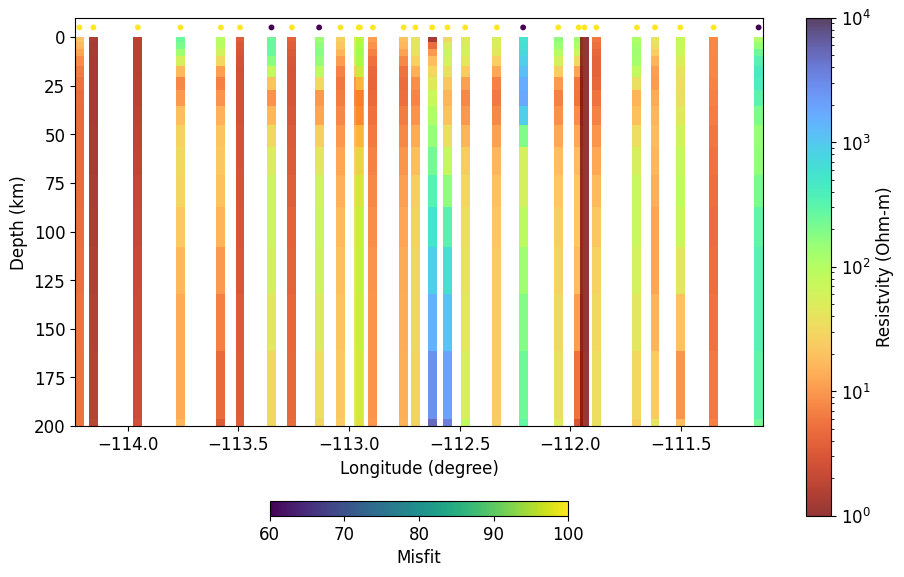

In [14]:
fig = plt.figure(figsize=(10, 6))
for ii in range(len(lon)):
    x_tmp = [lon[ii]-dx, lon[ii]+dx]
    out = plt.pcolormesh(x_tmp, depth/1e3, RHO[ii,::-1].reshape([-1,1]), norm=LogNorm(vmin=1e0, vmax=10000), cmap='turbo_r', alpha=0.8)
out_misfit = plt.scatter(lon, np.ones(len(lon)) * -0.5e1, c=phid_s, s=10, vmin=60, vmax=100)

plt.ylim(200, -1e1)
cb = plt.colorbar(out)
cb.set_label("Resistvity (Ohm-m)")
plt.xlabel("Longitude (degree)")
plt.ylabel("Depth (km)")
cb_mis = plt.colorbar(out_misfit, orientation='horizontal', fraction=0.03)
cb_mis.set_label("Misfit")


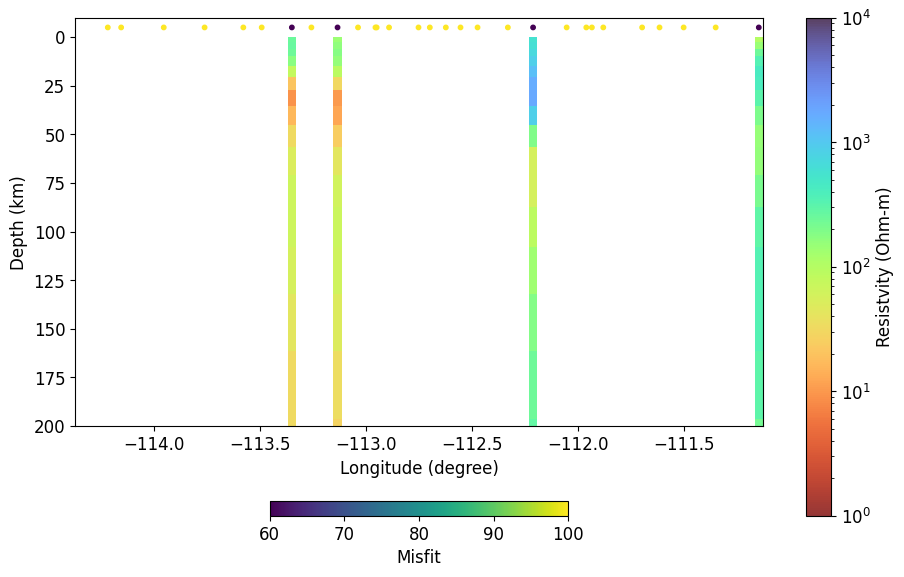

In [15]:
fig = plt.figure(figsize=(10, 6))
inds_bad = []
for ii in range(len(lon)):
    if phid_s[ii]<100:
        x_tmp = [lon[ii]-dx, lon[ii]+dx]
        out = plt.pcolormesh(x_tmp, depth/1e3, RHO[ii,::-1].reshape([-1,1]), norm=LogNorm(vmin=1e0, vmax=10000), cmap='turbo_r', alpha=0.8)
    else:
        inds_bad.append(ii)
out_misfit = plt.scatter(lon, np.ones(len(lon)) * -0.5e1, c=phid_s, s=10, vmin=60, vmax=100)

plt.ylim(200, -1e1)
cb = plt.colorbar(out)
cb.set_label("Resistvity (Ohm-m)")
plt.xlabel("Longitude (degree)")
plt.ylabel("Depth (km)")
cb_mis = plt.colorbar(out_misfit, orientation='horizontal', fraction=0.03)
cb_mis.set_label("Misfit")


In [16]:
# Plot station with a high misfit
# ii = 0
# tf = mc.get_tf(station_ids[inds_bad[ii]])
# tf.plot_mt_response()
# print (phid_s[inds_bad[ii]])